#### TMDB Box Office Prediction:
* Description: In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall
worldwide box office revenue.
* Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.
* You can also collect other public data to make the prediction.

##### Download the data through the API

`! pip install kaggle`  
`! kaggle competitions download -c tmdb-box-office-prediction`

For this, we need to ensure that the necessary requirements are setup accordingly. More information [here](https://github.com/Kaggle/kaggle-api).

### !!! IMPORTANT

- https://www.kaggle.com/code/praxitelisk/tmdb-box-office-prediction-eda-ml/notebook (indepth analysis: mostly use this for our project).
- https://medium.com/@prabhakaran_arivalagan/kaggle-competition-tmdb-box-office-prediction-using-random-forest-a2059be7bfff (bit more intuitive)
- https://github.com/nickmitch21/TMDB-Box-Office-Prediction/tree/master (other people's attempts)

In [759]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import ast

train =pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")

In [760]:
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

Shape of training data: (3000, 23)
Shape of testing data: (4398, 22)


In [761]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [762]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [763]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


In [764]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [765]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [766]:
#majority are null for these columns, so we remove these columns

train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

train.drop(['homepage'], axis=1, inplace=True)
test.drop(['homepage'], axis=1, inplace=True)

#irrelevant to our purpose
train.drop(['imdb_id'], axis=1, inplace=True)
test.drop(['imdb_id'], axis=1, inplace=True)

train.drop(['poster_path'], axis=1, inplace=True)
test.drop(['poster_path'], axis=1, inplace=True)

train.drop(['overview'], axis=1, inplace=True)
test.drop(['overview'], axis=1, inplace=True)

#original language information already presernt
train.drop(['spoken_languages'], axis=1, inplace=True)
test.drop(['spoken_languages'], axis=1, inplace=True)

#original title and title are considered redundant
train.drop(['original_title'], axis=1, inplace=True)
test.drop(['original_title'], axis=1, inplace=True)


#whether a movie is released or not does not matter
train.drop(['status'], axis=1, inplace=True)
test.drop(['status'], axis=1, inplace=True)

#we assume release data and keywords do not make a different
train.drop(['tagline'], axis=1, inplace=True)
test.drop(['tagline'], axis=1, inplace=True)

train.drop(['Keywords'], axis=1, inplace=True)
test.drop(['Keywords'], axis=1, inplace=True)

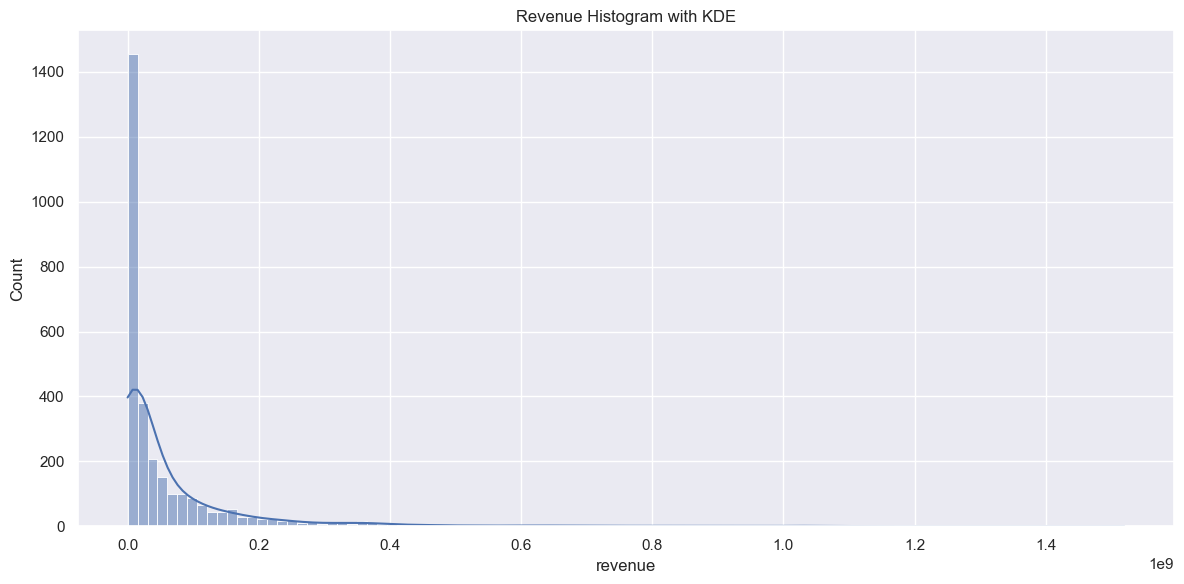

In [767]:
#revenue distrbution
f, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(train.revenue, kde=True, bins=100)  
ax.set_title("Revenue Histogram with KDE")
f.tight_layout()

train["log_revenue"] = np.log1p(train["revenue"])

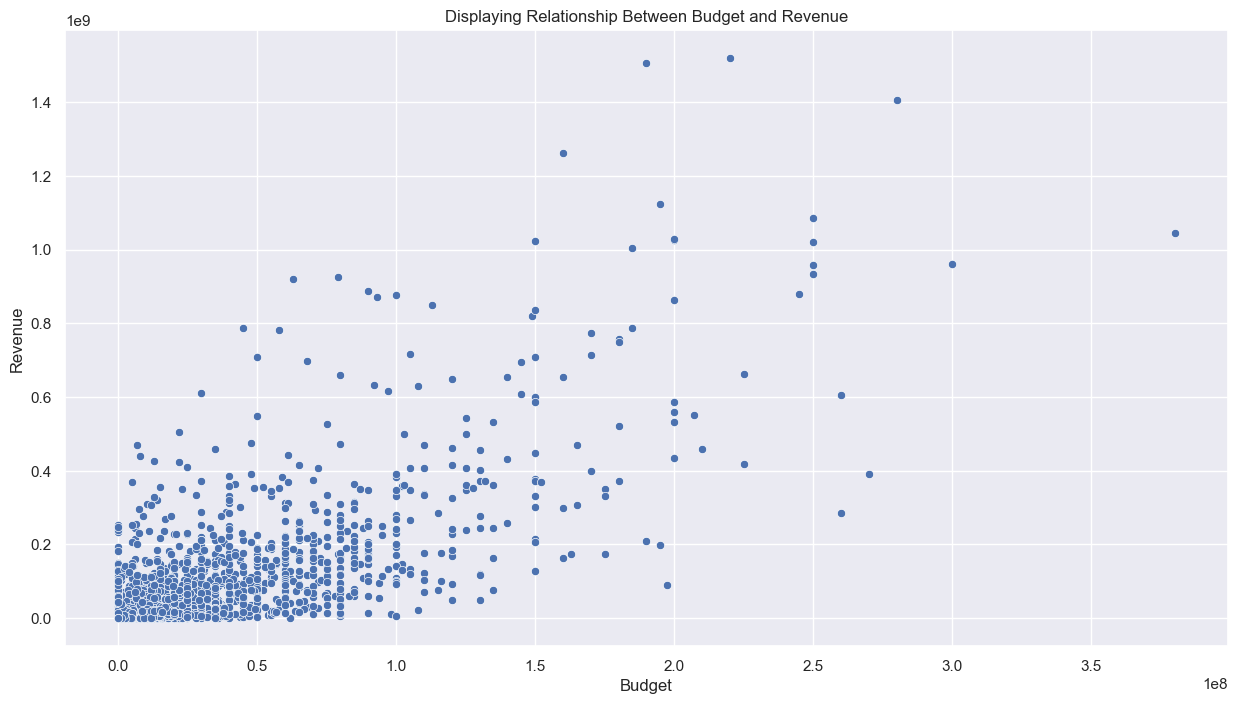

In [768]:
#Association between budget and revenue

sns.scatterplot(x=train['budget'], y=train['revenue'])

# Set titles and labels
plt.title('Displaying Relationship Between Budget and Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# Show the plot
plt.show()

This shows that there are many low budget movie that could hamper our analysis. Hence, we are going to remove all low-budget movies, and use a log scale for better visualization.

In [769]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

(array([ 16.,   7.,  15.,  34.,  25.,  47.,  55.,  89., 127., 152., 154.,
        239., 264., 268., 211., 201., 143.,  64.,  34.,   6.]),
 array([11.51293546, 11.92507278, 12.3372101 , 12.74934742, 13.16148473,
        13.57362205, 13.98575937, 14.39789669, 14.810034  , 15.22217132,
        15.63430864, 16.04644596, 16.45858327, 16.87072059, 17.28285791,
        17.69499523, 18.10713254, 18.51926986, 18.93140718, 19.3435445 ,
        19.75568181]),
 <BarContainer object of 20 artists>)

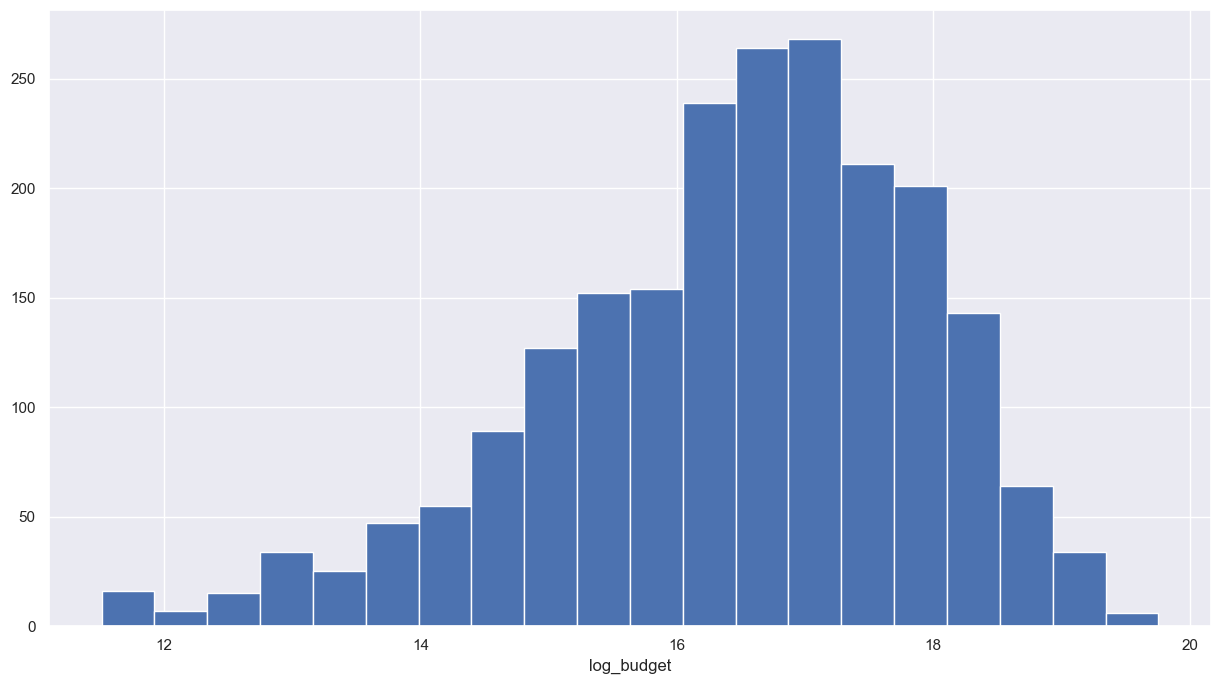

In [770]:
train = train[train['budget'] >= 100000]

plt.xlabel( 'log_budget')
plt.hist(train['log_budget'],bins = 20)

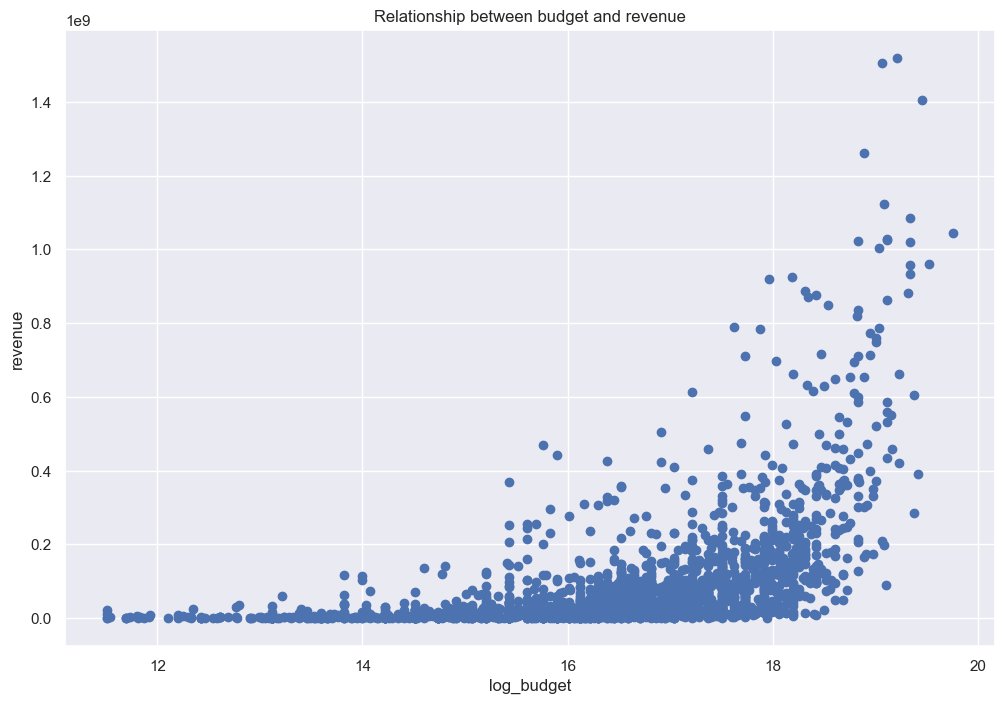

In [771]:
plt.figure(figsize=(12, 8)) 
plt.title('Relationship between budget and revenue')
plt.xlabel( 'log_budget')
plt.ylabel('revenue')
plt.scatter(x=train['log_budget'], y=train['revenue'])

In [772]:
def process_genres(df, top_genres=None):
    # Read the dictionary in proper format
    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Count the number of times each genre appears
    genre_counts = df['genres'].explode().apply(lambda x: x['name'] if isinstance(x, dict) else None).value_counts()

    # If top_genres is None, find the top 5 genres from this DataFrame
    if top_genres is None:
        top_genres = genre_counts.nlargest(5).index.tolist()

    # New columns
    for genre in top_genres:
        df[f'is_genre_{genre}'] = df['genres'].apply(
            lambda genres: 1 if isinstance(genres, list) and any(g['name'] == genre for g in genres) else 0
        )

    return top_genres  

top_5_genres = process_genres(train)
process_genres(test, top_genres=top_5_genres)

train.drop(['genres'], axis=1, inplace=True)
test.drop(['genres'], axis=1, inplace=True)

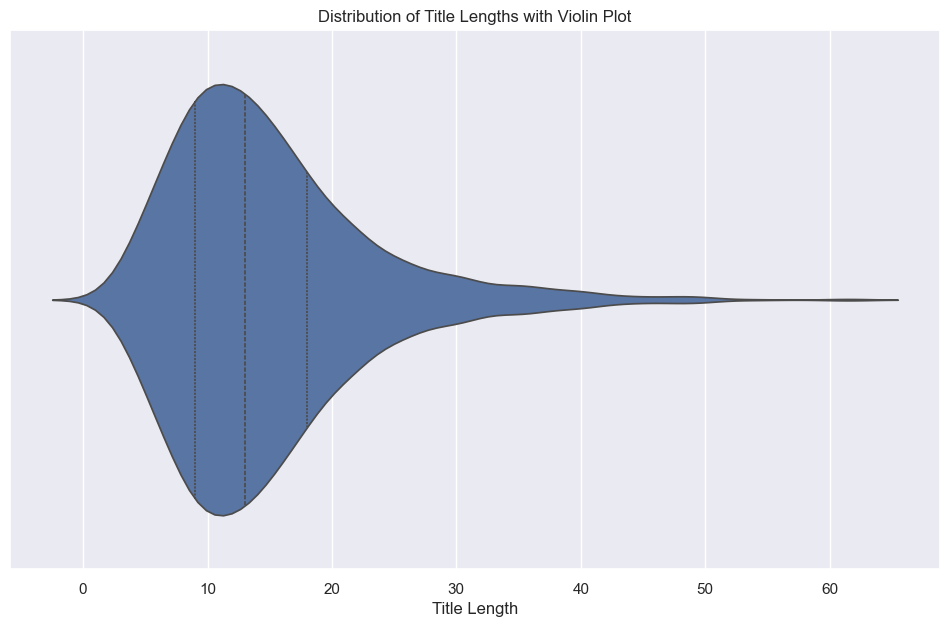

In [773]:
#title length NA handling
train["title"] = train["title"].fillna("")
test["title"] = test["title"].fillna("")

train["title_len"] = train["title"].apply(len)
test["title_len"] = test["title"].apply(len)

plt.figure(figsize=(12, 7))
sns.violinplot(x=train["title_len"], inner="quartile")
plt.title("Distribution of Title Lengths with Violin Plot")
plt.xlabel("Title Length")
plt.show()

train.drop(['title'], axis=1, inplace=True)
test.drop(['title'], axis=1, inplace=True)


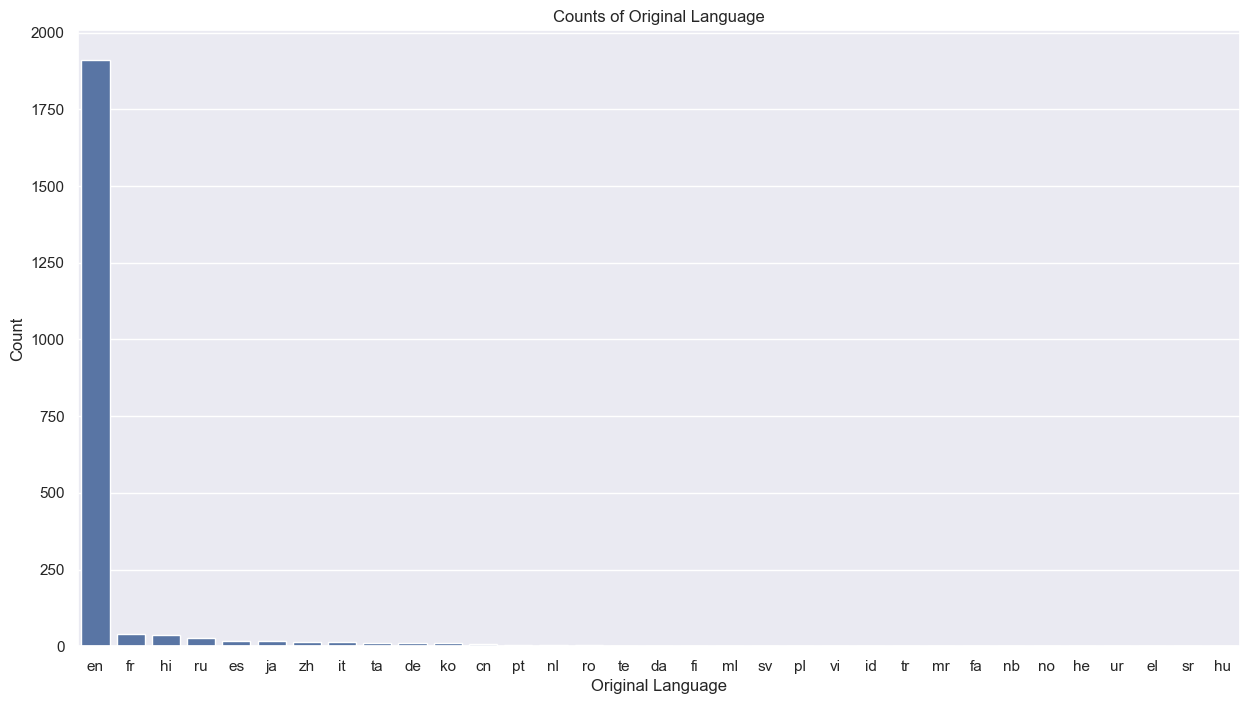

In [774]:
#counting the languages
sns.set(rc={'figure.figsize': (15, 8)})

# Create a count plot for original_language
sns.countplot(x='original_language', data=train, order=train['original_language'].value_counts().index)

# Set title and labels
plt.title('Counts of Original Language')
plt.xlabel('Original Language')
plt.ylabel('Count')

# Show the plot
plt.show()

In [775]:
#feature engineering
for i in train['original_language']:
    if i == 'en':
        train['Has_En'] = 1
    else:
        train['Has_En'] = 0

for j in test['original_language']:
    if j == 'en':
        test['Has_En'] = 1
    else:
        test['Has_En'] = 0

#drop language data later
train.drop(['original_language'], axis=1, inplace=True)
test.drop(['original_language'], axis=1, inplace=True)

In [776]:
#extract dictionary information
train['production_companies'] = train['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test['production_companies'] = test['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

train['production_company_names'] = train['production_companies'].apply(lambda x: [company['name'] for company in x] if isinstance(x, list) else [])
test['production_company_names'] = test['production_companies'].apply(lambda x: [company['name'] for company in x] if isinstance(x, list) else [])

# count occurrences
company_counts = train['production_company_names'].explode().value_counts()

#assign scores based on counts
scores = pd.DataFrame(company_counts).reset_index()
scores.columns = ['production_company', 'count']
scores['score'] = scores['count'].rank(method='min', ascending=False)

#create a mapping of and calculate mean score
score_mapping = scores.set_index('production_company')['score'].to_dict()

train['production_company_score'] = train['production_company_names'].apply(
    lambda companies: np.mean([score_mapping.get(company, 0) for company in companies]) if companies else np.nan
)

test['production_company_score'] = test['production_company_names'].apply(
    lambda companies: np.mean([score_mapping.get(company, 0) for company in companies]) if companies else np.nan
)

/var/folders/nt/67mjll3s4fb1vnp8mvn0q2kh0000gn/T/ipykernel_6534/4260284003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='production_company', y='count', data=top_15_companies, palette='viridis')


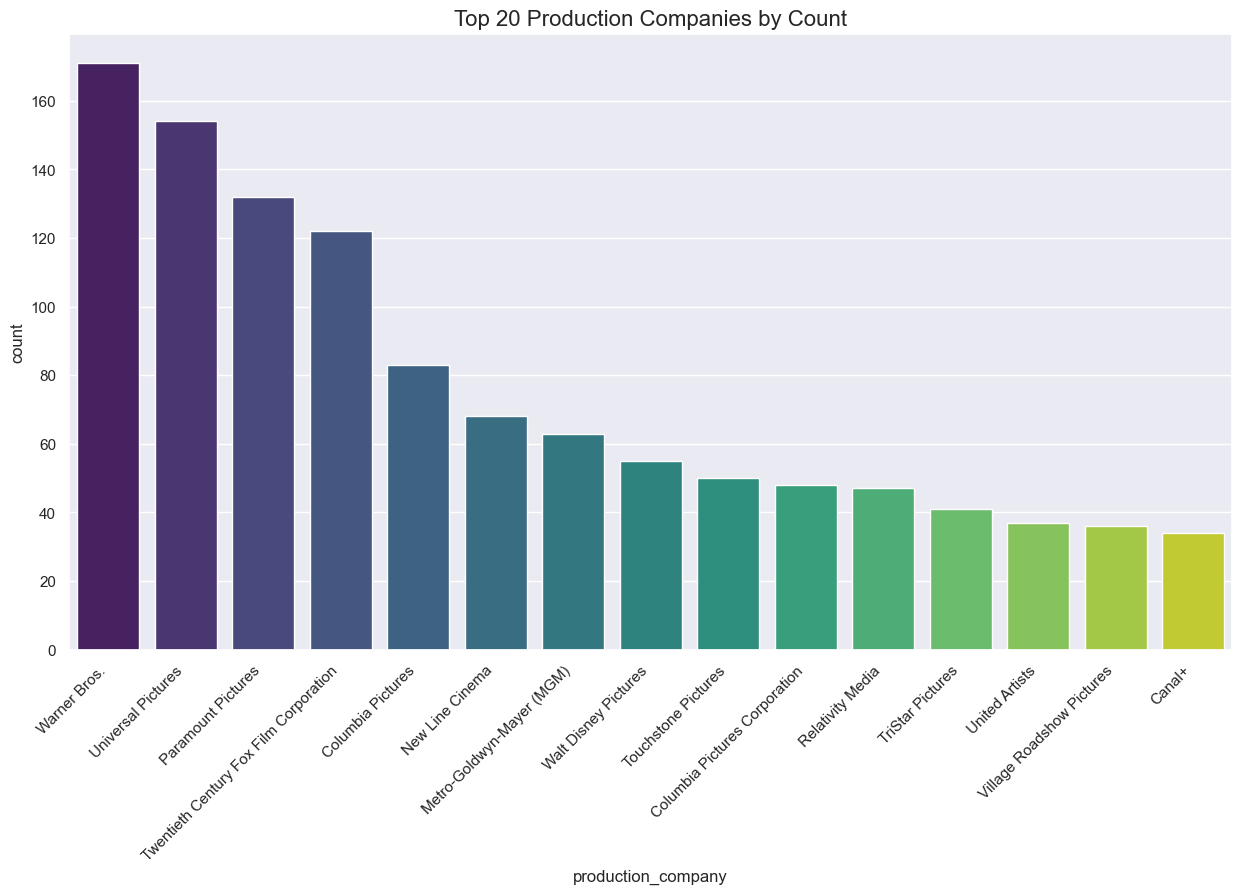

In [777]:
top_15_companies = scores.nlargest(15, 'count')

sns.barplot(x='production_company', y='count', data=top_15_companies, palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Production Companies by Count', fontsize=16)
plt.show()

train.drop(['production_companies', 'production_company_names'], axis=1, inplace=True)
test.drop(['production_companies', 'production_company_names'], axis=1, inplace=True)

In [778]:
#extracting the production country
def extract_production_country(countries):
    try:
        d = ast.literal_eval(countries) 
    except (ValueError, SyntaxError):
        return np.NaN  

    if isinstance(d, list) and len(d) > 0:
        if len(d) > 1:
            country_names = [country['name'] for country in d]
            # Check for 'United States of America'
            if 'United States of America' in country_names:
                return 'United States of America'
            else:
                return country_names[0]  # Return the first country if USA is not present
        else:
            return d[0]['name']  # Return the single country's name
    return np.NaN  # Return NaN if the list is empty

train['production_country'] = train['production_countries'].apply(extract_production_country)
test['production_country'] = test['production_countries'].apply(extract_production_country)

# Display counts of each production country
train['production_country'].value_counts()

production_country
United States of America    1760
India                         63
France                        53
United Kingdom                53
Russia                        26
Canada                        19
China                         17
Italy                         16
Japan                         16
Australia                     15
Germany                       11
Spain                         10
Hong Kong                      7
South Korea                    7
Belgium                        6
Brazil                         4
Finland                        4
Denmark                        4
Ireland                        4
Austria                        4
Mexico                         3
New Zealand                    3
Czech Republic                 3
Argentina                      2
Romania                        2
Ukraine                        2
Norway                         2
Sweden                         2
Netherlands                    2
Israel                  

In [779]:
#since most movies were produced in the US
train['prod_is_US'] = np.where(train['production_country'] == 'United States of America', 1,
                                    np.where(train['production_country'].isna(), np.NaN, 0))

test['prod_is_US'] = np.where(test['production_country'] == 'United States of America', 1,
                                   np.where(test['production_country'].isna(), np.NaN, 0))

train.drop(['production_countries', 'production_country'], axis=1, inplace=True)
test.drop(['production_countries', 'production_country'], axis=1, inplace=True)

In [780]:
print(train['runtime'].isnull().sum())

#mean imputation of runtime
train['runtime']=train['runtime'].fillna(train['runtime'].mean()).round()
test['runtime']=test['runtime'].fillna(test['runtime'].mean()).round()  

1


<Axes: xlabel='runtime', ylabel='revenue'>

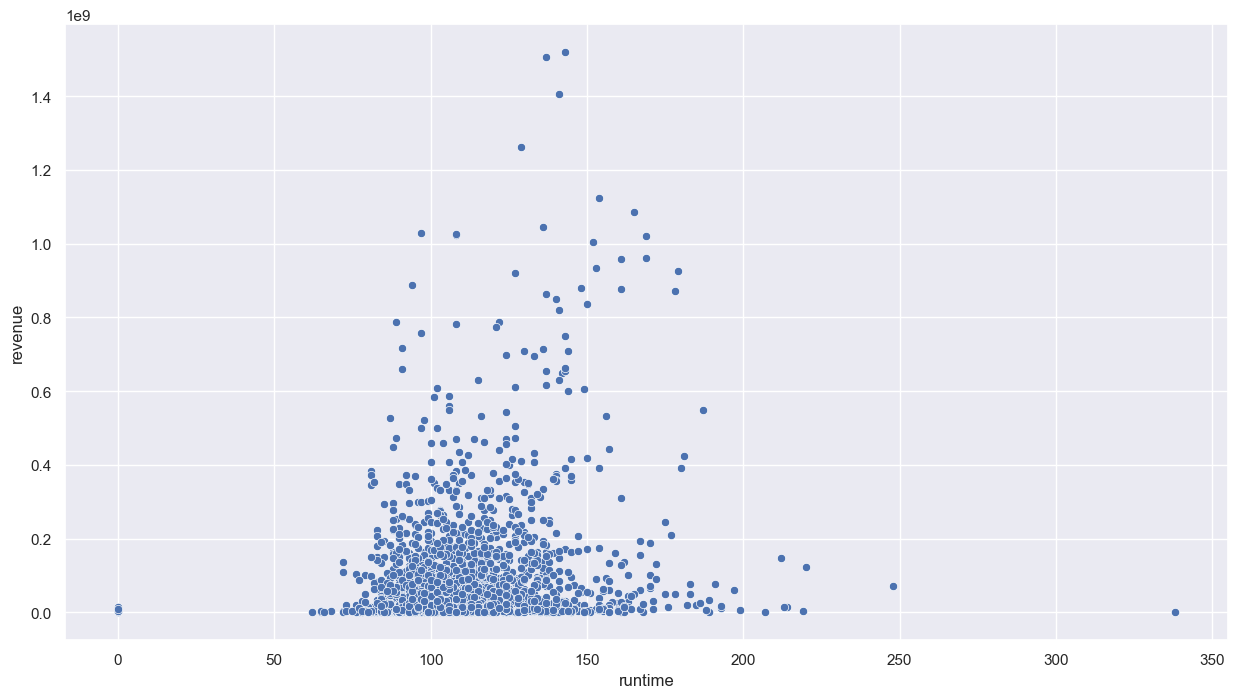

In [781]:
#do longer movies make more money?
sns.scatterplot(x='runtime', y='revenue', data=train)

In [782]:
#surely release timing has an effect
train['release_date'] = pd.to_datetime(train['release_date'], errors='coerce', format='%m/%d/%y')

train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_week'] = train['release_date'].dt.isocalendar().week  

#do the same for test
test['release_date'] = pd.to_datetime(test['release_date'], errors='coerce', format='%m/%d/%y')

test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
test['release_week'] = test['release_date'].dt.isocalendar().week  

#invalid year data
print("Movies with invalid years:", len(train[train['release_year'] > 2024]))

#set them as NaN
train.loc[train['release_year'] > 2024, 'release_year'] = np.NaN
test.loc[test['release_year'] > 2024, 'release_year'] = np.NaN

train.drop(['release_date'], axis=1, inplace=True)
test.drop(['release_date'], axis=1, inplace=True)

Movies with invalid years: 108


In [783]:
#extract dictionary information
train['cast'] = train['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test['cast'] = test['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#maintain num_cast column
train['num_cast'] = train['cast'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test['num_cast'] = test['cast'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#drop the existing cast column
train.drop('cast', axis=1, inplace=True)
test.drop('cast', axis=1, inplace=True)


In [784]:
def process_crew(df):
    #extract dictionary information
    df['crew'] = df['crew'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    #maintain num_crew count
    df['num_crew'] = df['crew'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    #drop the 'crew' column
    df.drop('crew', axis=1, inplace=True)

process_crew(train)
process_crew(test)

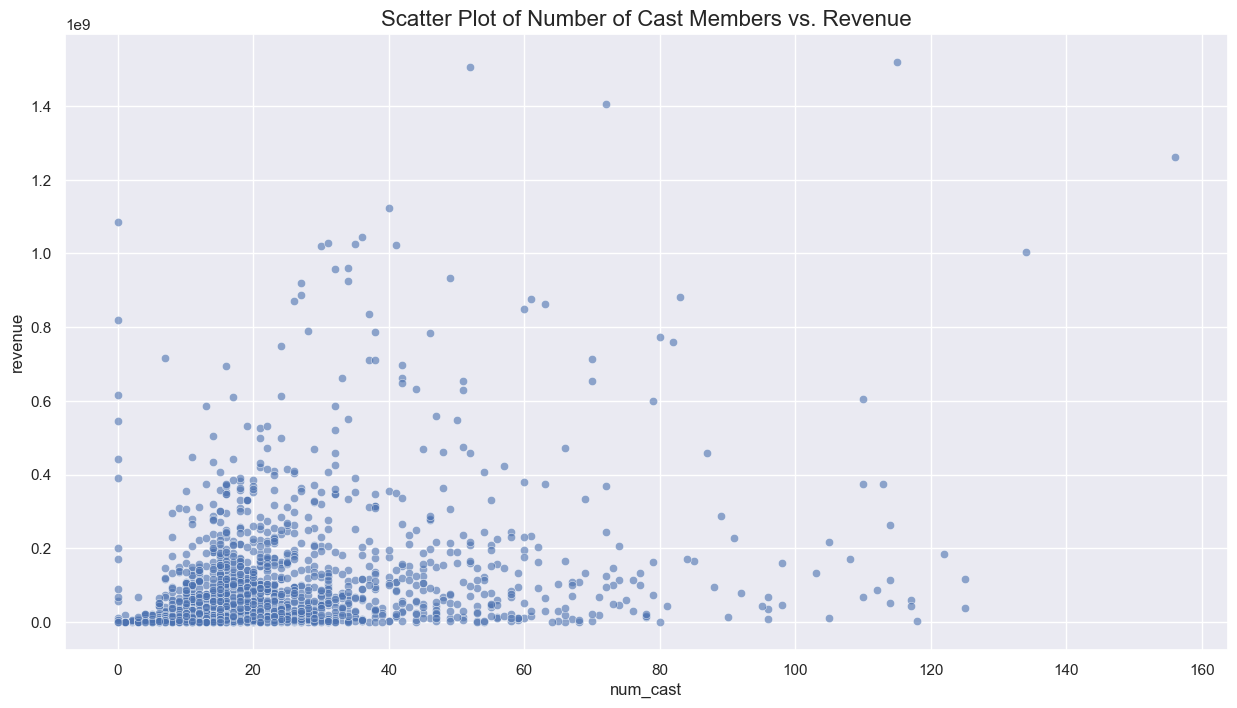

In [785]:
sns.scatterplot(x='num_cast', y='revenue', data=train, alpha=0.6)
plt.title('Scatter Plot of Number of Cast Members vs. Revenue', fontsize=16)
plt.show()

In [786]:
#check structure of data after cleaning
train.head()

,id,budget,popularity,runtime,revenue,log_revenue,log_budget,is_genre_Drama,is_genre_Comedy,is_genre_Thriller,...,is_genre_Romance,title_len,Has_En,production_company_score,prod_is_US,release_year,release_month,release_week,num_cast,num_crew
0,1,14000000,6.575393,93.0,12314651,16.326300,16.454568,0,1,0,...,0,22,1,7.666667,1.0,2015.0,2,8,24,72
1,2,40000000,8.248895,113.0,95149435,18.370959,17.504390,1,1,0,...,1,40,1,8.000000,1.0,2004.0,8,32,20,9
2,3,3300000,64.299990,105.0,13092000,16.387512,15.009433,1,0,0,...,0,8,1,166.666667,1.0,2014.0,10,41,51,64
3,4,1200000,3.174936,122.0,16000000,16.588099,13.997833,1,0,1,...,0,7,1,NaN,0.0,2012.0,3,10,7,3
5,6,8000000,0.743274,83.0,3261638,14.997740,15.894952,0,0,0,...,0,38,1,NaN,NaN,1987.0,8,32,4,11


In [793]:
test.head()

,id,budget,popularity,runtime,log_budget,is_genre_Drama,is_genre_Comedy,is_genre_Thriller,is_genre_Action,is_genre_Romance,title_len,Has_En,production_company_score,prod_is_US,release_year,release_month,release_week,num_cast,num_crew
0,3001,0,3.851534,90.0,0.000000,0,0,0,0,0,28,0,NaN,1.0,2007.0,7.0,28,7,2
1,3002,88000,3.559789,65.0,11.385103,0,0,0,0,0,27,0,0.000000,1.0,NaN,5.0,20,10,8
2,3003,0,8.085194,100.0,0.000000,0,1,0,0,1,16,0,167.666667,1.0,1997.0,5.0,21,9,10
3,3004,6800000,8.596012,130.0,15.732433,1,0,0,0,0,9,0,0.000000,0.0,NaN,NaN,<NA>,23,69
4,3005,2000000,3.217680,92.0,14.508658,0,0,0,0,0,18,0,NaN,1.0,NaN,NaN,<NA>,4,14


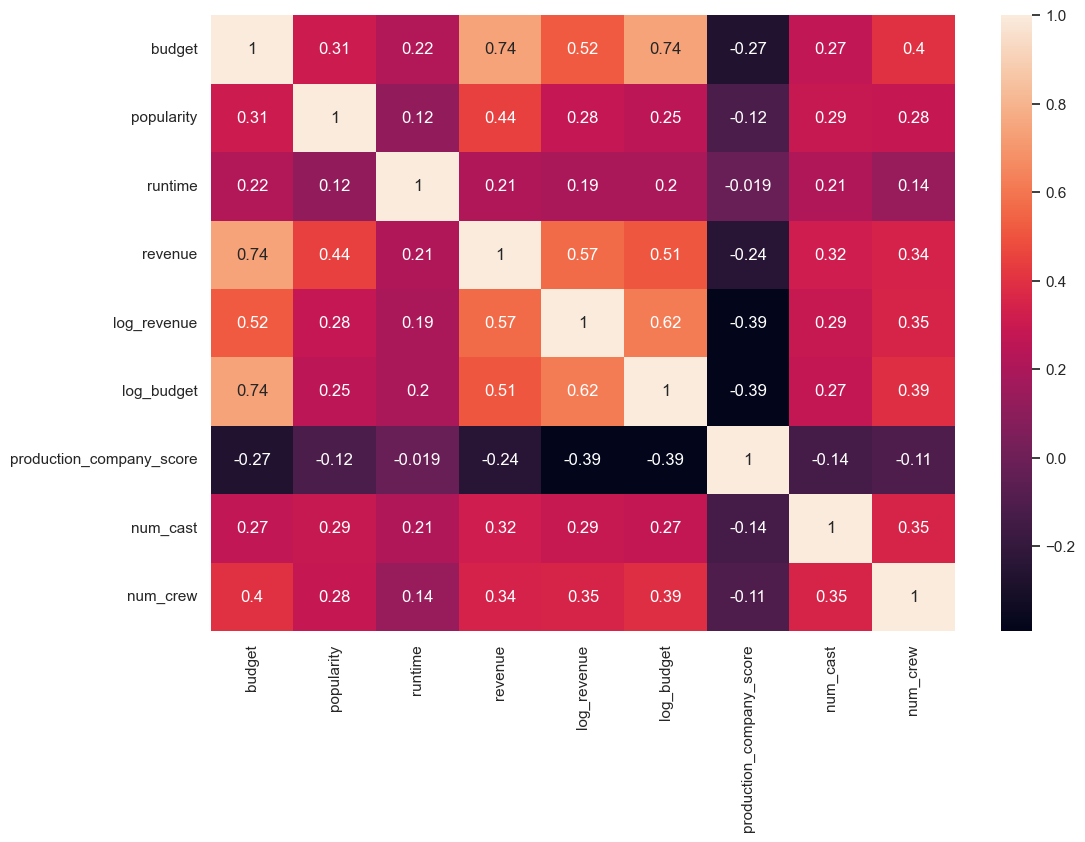

In [795]:
corr =train.corr()
top_feature = corr.index[abs(corr['revenue'])>0.2]

#Correlation plot
plt.subplots(figsize=(12, 8))
top_corr = train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [788]:
#preproceess data onto clean format


In [789]:
#Exploratory Data Analysis beforehand

In [790]:
#train model #1 (Random Forest) and run prediction on test set

In [791]:
#train model #2 (simple Linear Regression) and run prediction on test set

In [792]:
#compare performance of two models

#### Final Wrapup